# Explore Exercises

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from scipy import stats

from env import host, user, password
import wrangle
import explore

In [75]:
zillow = pd.read_sql('''
SELECT prop.parcelid, prop.bathroomcnt, prop.bedroomcnt, prop.calculatedbathnbr, 
prop.calculatedfinishedsquarefeet, prop.fullbathcnt, prop.propertylandusetypeid, 
prop.regionidcity, prop.regionidcounty, prop.regionidzip, prop.yearbuilt, prop.structuretaxvaluedollarcnt, prop.taxvaluedollarcnt, 
prop.taxamount, pred.transactiondate
FROM properties_2017 as prop
JOIN predictions_2017 as pred ON prop.id = pred.id
WHERE pred.transactiondate BETWEEN '2017-05-01'
							AND '2017-08-31'
		AND prop.propertylandusetypeid = '261'
ORDER BY pred.transactiondate DESC;
''', wrangle.get_connection('zillow'))

In [76]:
zillow.shape

(30605, 15)

In [77]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30605 entries, 0 to 30604
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      30605 non-null  int64  
 1   bathroomcnt                   30605 non-null  float64
 2   bedroomcnt                    30605 non-null  float64
 3   calculatedbathnbr             30436 non-null  float64
 4   calculatedfinishedsquarefeet  30513 non-null  float64
 5   fullbathcnt                   30436 non-null  float64
 6   propertylandusetypeid         30605 non-null  float64
 7   regionidcity                  30050 non-null  float64
 8   regionidcounty                30605 non-null  float64
 9   regionidzip                   30566 non-null  float64
 10  yearbuilt                     30505 non-null  float64
 11  structuretaxvaluedollarcnt    30520 non-null  float64
 12  taxvaluedollarcnt             30600 non-null  float64
 13  t

In [78]:
def prep_zillow(df):
    #Calculated bathnbr seems to correspond 1:1 with the number of bathrooms 
    df.calculatedbathnbr = df.calculatedbathnbr.fillna(df.bathroomcnt)
    
    #Calculate missing nulls in fullbathcnt which corresponds to bath counts ROUNDED down (removes half baths)
    df.fullbathcnt = df.fullbathcnt.fillna(df.bathroomcnt).apply(np.floor)
    
    #Drop transaction date
    df.drop(columns='transactiondate', inplace=True)
    
    #Drop remaining observations with missing values
    df.dropna(inplace=True)
    
    #Convert Zipcode to int
    df.regionidzip = df.regionidzip.astype('int64')
    
    #Convert Yearbuilt to int
    df.yearbuilt = df.yearbuilt.astype('int64')
    
    #reset index
    df = df.set_index('parcelid')
    
    return df

In [79]:
zillow = prep_zillow(zillow)

In [80]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29908 entries, 14306741 to 10947382
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   29908 non-null  float64
 1   bedroomcnt                    29908 non-null  float64
 2   calculatedbathnbr             29908 non-null  float64
 3   calculatedfinishedsquarefeet  29908 non-null  float64
 4   fullbathcnt                   29908 non-null  float64
 5   propertylandusetypeid         29908 non-null  float64
 6   regionidcity                  29908 non-null  float64
 7   regionidcounty                29908 non-null  float64
 8   regionidzip                   29908 non-null  int64  
 9   yearbuilt                     29908 non-null  int64  
 10  structuretaxvaluedollarcnt    29908 non-null  float64
 11  taxvaluedollarcnt             29908 non-null  float64
 12  taxamount                     29908 non-null  floa

In [81]:
train, validate, test = wrangle.train_validate_test_split(zillow)
train.shape, validate.shape, test.shape

((16748, 13), (7178, 13), (5982, 13))

In [82]:
train.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount
parcelid,,,,,,,,,,,,,
10966090,1.0,2.0,1.0,773.0,1.0,261.0,12447.0,3101.0,96368,1955,110977.0,221806.0,2767.89
11849115,3.0,4.0,3.0,2377.0,3.0,261.0,6021.0,3101.0,96497,1952,69773.0,99572.0,1529.51
12847795,3.0,4.0,3.0,2453.0,3.0,261.0,22827.0,3101.0,96492,1985,186110.0,454559.0,5752.26
14058303,2.5,4.0,2.5,2765.0,2.0,261.0,25218.0,1286.0,96964,1979,239701.0,888768.0,10017.02
10718851,4.0,4.0,4.0,2862.0,4.0,261.0,12447.0,3101.0,96339,1984,410788.0,732240.0,8992.46


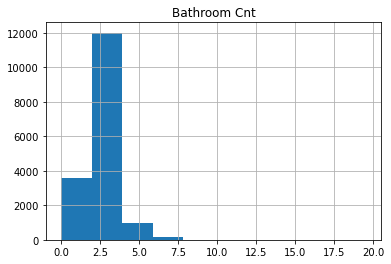

In [88]:
train.bathroomcnt.hist()
plt.title('Bathroom Cnt')
plt.show()

### Takeaways:
    - Check for outliers and possibly remove

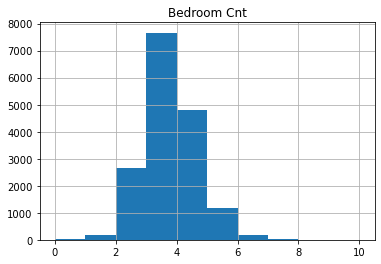

In [89]:
train.bedroomcnt.hist()
plt.title('Bedroom Cnt')
plt.show()

### Takeaways:
    - Looks good...maybe an outlier that needs attention

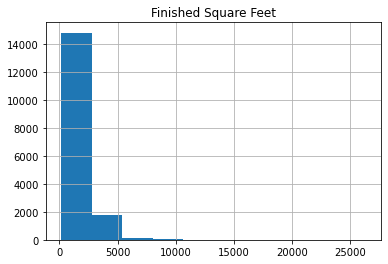

In [90]:
train.calculatedfinishedsquarefeet.hist()
plt.title('Finished Square Feet')
plt.show()

### Takeaways:
    - Definitely some outliers to deal with

<AxesSubplot:>

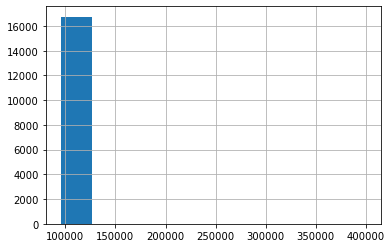

In [93]:
train.regionidzip.hist()

### Takeaways:
    - Look at zipcode dist through a frequency table

<AxesSubplot:>

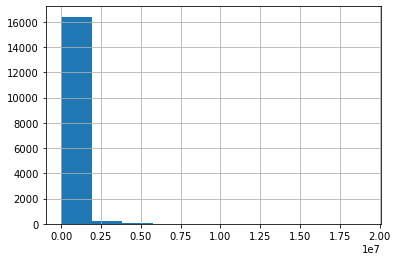

In [95]:
train.taxvaluedollarcnt.hist()

### Takeaways:
    - Outliers here too?

<AxesSubplot:>

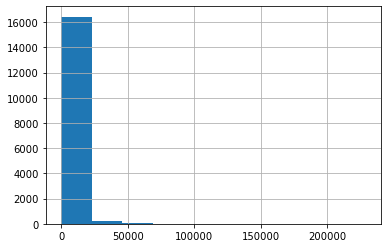

In [96]:
train.taxamount.hist()

### Takeaways:
    - Need to deal with outliers

## Deal with outliers

In [98]:
train.describe()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount
count,16748.000000,16748.000000,16748.000000,16748.000000,16748.000000,16748.0,16748.000000,16748.000000,16748.000000,16748.000000,1.674800e+04,1.674800e+04,16748.000000
mean,2.228356,3.289885,2.228356,1843.163781,2.177036,261.0,36107.948292,2564.844638,96554.302424,1959.960115,1.717482e+05,4.554878e+05,5551.194968
std,0.990141,0.925982,0.990141,967.729786,0.973712,0.0,55261.963290,801.819518,3337.209250,21.469462,2.283288e+05,6.189181e+05,7129.538278
min,0.000000,0.000000,0.000000,160.000000,0.000000,261.0,3491.000000,1286.000000,95982.000000,1880.000000,1.080000e+02,3.257000e+03,37.650000
25%,2.000000,3.000000,2.000000,1249.000000,2.000000,261.0,12447.000000,1286.000000,96186.000000,1949.000000,7.301575e+04,1.825875e+05,2470.390000
50%,2.000000,3.000000,2.000000,1612.000000,2.000000,261.0,24832.000000,3101.000000,96383.000000,1957.000000,1.192935e+05,3.255015e+05,4090.970000
75%,3.000000,4.000000,3.000000,2186.000000,3.000000,261.0,45457.000000,3101.000000,96982.000000,1973.000000,1.958662e+05,5.303570e+05,6358.652500
max,19.500000,10.000000,19.500000,26345.000000,19.000000,261.0,396556.000000,3101.000000,399675.000000,2015.000000,8.225708e+06,1.912982e+07,228999.210000


In [104]:
train.shape

(16748, 13)

In [100]:
# Find the IQR
q1 = train.taxvaluedollarcnt.quantile(.25)
q3 = train.taxvaluedollarcnt.quantile(.75)
q1, q3

(182587.5, 530357.0)

In [101]:
iqr = q3 - q1
iqr

347769.5

In [102]:
multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

In [103]:
upper_bound, lower_bound

(1052011.25, -339066.75)

In [105]:
# Let's filter out the upper value outliers
train = train[train.taxvaluedollarcnt < upper_bound]
train.shape

(15681, 13)

<AxesSubplot:>

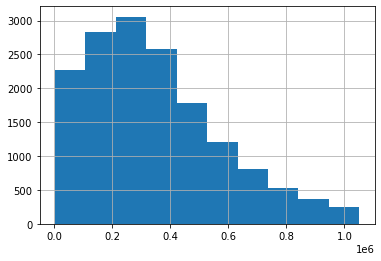

In [107]:
train.taxvaluedollarcnt.hist()

<AxesSubplot:>

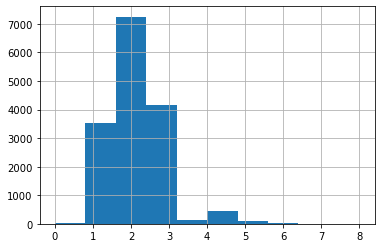

In [108]:
train.bathroomcnt.hist()

In [109]:
train.corr()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount
bathroomcnt,1.000000,0.613705,1.000000,0.790804,0.983507,NaN,-0.034957,-0.159253,0.090870,0.509045,0.637622,0.409869,0.412401
bedroomcnt,0.613705,1.000000,0.613705,0.615546,0.602528,NaN,-0.034581,-0.164621,0.056398,0.355267,0.404755,0.232385,0.234737
calculatedbathnbr,1.000000,0.613705,1.000000,0.790804,0.983507,NaN,-0.034957,-0.159253,0.090870,0.509045,0.637622,0.409869,0.412401
calculatedfinishedsquarefeet,0.790804,0.615546,0.790804,1.000000,0.767803,NaN,-0.028089,-0.167805,0.085491,0.444616,0.727284,0.479480,0.476494
fullbathcnt,0.983507,0.602528,0.983507,0.767803,1.000000,NaN,-0.027429,-0.075986,0.082516,0.461855,0.614290,0.386420,0.395237
propertylandusetypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regionidcity,-0.034957,-0.034581,-0.034957,-0.028089,-0.027429,NaN,1.000000,0.094330,-0.017983,-0.091786,-0.009615,0.020252,0.014091
regionidcounty,-0.159253,-0.164621,-0.159253,-0.167805,-0.075986,NaN,0.094330,1.000000,-0.102503,-0.350251,-0.069108,-0.158668,-0.089132
regionidzip,0.090870,0.056398,0.090870,0.085491,0.082516,NaN,-0.017983,-0.102503,1.000000,0.073958,0.017336,0.001860,-0.002083
yearbuilt,0.509045,0.355267,0.509045,0.444616,0.461855,NaN,-0.091786,-0.350251,0.073958,1.000000,0.493280,0.261797,0.263375


### Takeaways:
    - calculatedbathnbr correlates with bathroomcnt but not as strong as bedroomcnt
        - but bedroomcnt doesnt really correlate too strongly with tax amount anyways...so maybe drop bedroom and bathroom cnt in favor of the calculated bathroom and bedroom cnt
    - Sq feet correlates with structure tax value count ==> Expected
    - Yearbuilt correlates most closely with bathroom cnt..

In [111]:
cols_to_drop = ['calculatedbathnbr', 'fullbathcnt', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidzip']
train.drop(columns=cols_to_drop, inplace=True)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [112]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount
parcelid,,,,,,,
10966090,1.0,2.0,773.0,1955,110977.0,221806.0,2767.89
11849115,3.0,4.0,2377.0,1952,69773.0,99572.0,1529.51
12847795,3.0,4.0,2453.0,1985,186110.0,454559.0,5752.26
14058303,2.5,4.0,2765.0,1979,239701.0,888768.0,10017.02
10718851,4.0,4.0,2862.0,1984,410788.0,732240.0,8992.46


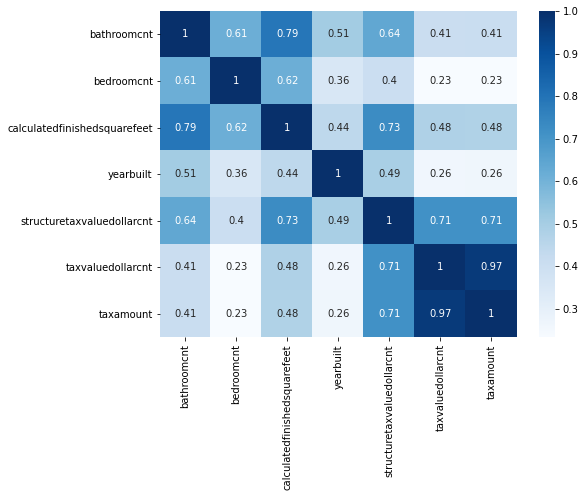

In [115]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.show()

### Takeaways:
    - Structure value count is more correlated with the features of the structure (bedrooms, bathrooms, squarefeet)
    - Those features may be the best drivers for the structure value dollar count
        - I may need for more features that are more correlated with the land value i.e. pool to better be able to predict the combined tax value dollar amount 
    - Year and structure value dollar count have a corr coefficient of .49... why is that? Is it significant?

### First Question/Test: Is calculated square feet a good feature for predicting tax value dollar count? Is there a correlation?

In [134]:
null_hypothesis = 'there is no correlation between the calculated square foot of a property and the tax value dollar count'
alt_hypothesis = 'there is a correlation between square feet and tax value dollar count'

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .99 # desired confidence interval
a = 1 - conf_interval

In [135]:
x = train.calculatedfinishedsquarefeet
y = train.taxvaluedollarcnt

corr, p = stats.pearsonr(x, y)
corr, p

(0.4794801025336692, 0.0)

In [136]:
if p < a:
    print('Reject the null hypothesis.')
    print(f'Move forward with the understanding that {alt_hypothesis}')

Reject the null hypothesis.
Move forward with the understanding that there is a correlation between square feet and tax value dollar count


## Second Question/Test: Does the number of bathrooms correlate with the tax value?

In [142]:
null_hypothesis = "number of bathrooms and a property's tax value have no corrleation"
alt_hypothesis = "number of bathrooms and a property's tax value do correlate"

conf_int = .99
a = 1 - conf_int

In [143]:
x = train.bathroomcnt
y = train.taxvaluedollarcnt

corr, p = stats.pearsonr(x, y)
corr, p

(0.40986897588045035, 0.0)

In [144]:
if p < a:
    print('Reject the null hypothesis.')
    print(f'Move forward with the understanding that {alt_hypothesis}')

Reject the null hypothesis.
Move forward with the understanding that number of bathrooms and a property's tax value do correlate
